In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.feature import hog
import glob
import os
import sklearn
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import itertools
from sklearn import grid_search
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
from cv2 import HOGDescriptor
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

C:\Users\keshav_aggarwal\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\keshav_aggarwal\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
from keras.models import load_model
clf = load_model('model_relu.h5')

Using TensorFlow backend.


In [3]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        
        #6) Predict using your classifier
        prediction = clf.predict(test_img[None, :, :, :], batch_size=1)
        #7) If positive (prediction == 1) then save the window
        if prediction > 0.5:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [4]:
##Sliding window implementation
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

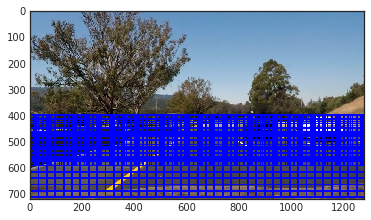

In [17]:
image = cv2.imread('test6.jpg')
#image = cv2.imread('test_images/test1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

xy_window = [(64,64), (96,96), (128,96)]
y_start_stop = [[400, 600], [400, 600], [400, None]]

windows_temp = []
for i in range(len(xy_window)):
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop[i], 
                        xy_window=xy_window[i], xy_overlap=(0.75, 0.75))
    windows_temp.append(windows) 

#Flatten windows_temp
windows_final = sum(windows_temp, [])


window_img = draw_boxes(image, windows_final, color=(0, 0, 255), thick=6)   
with sns.axes_style("white"):
    plt.imshow(window_img)

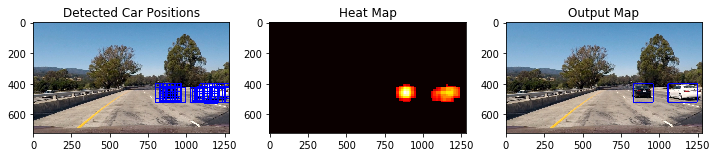

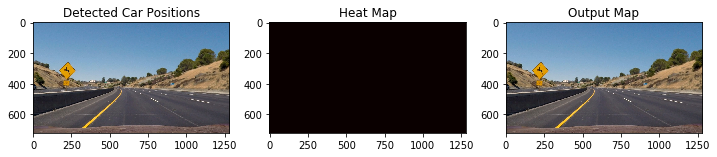

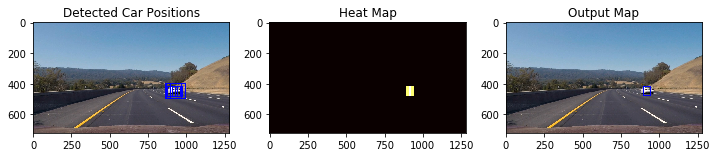

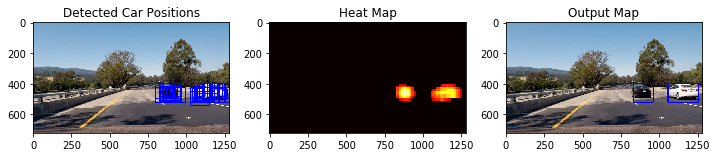

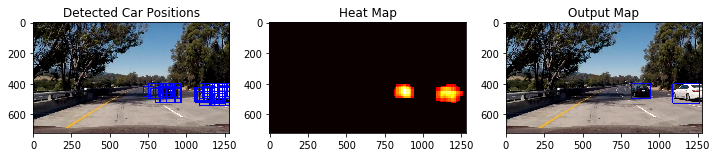

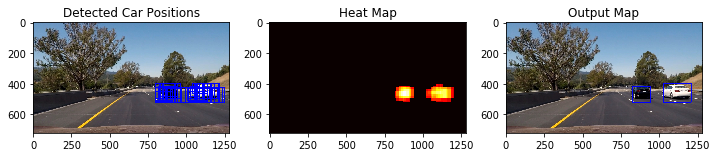

In [36]:
from scipy.ndimage.measurements import label
files = ['test_images/test1.jpg','test_images/test2.jpg','test_images/test3.jpg','test_images/test4.jpg','test_images/test5.jpg','test_images/test6.jpg']
for file in files:
    image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    draw_image = np.copy(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

#     xy_window = [(96,96),(128,128)]
#     y_start_stop = [[350, 600], [350, None]]

    xy_window = [(64,64), (96,96), (128,96)]
    y_start_stop = [[400, 600], [400, 600], [400, None]]
    windows_temp = []
    for i in range(len(xy_window)):
        windows = slide_window(image, x_start_stop=[700, None], y_start_stop=y_start_stop[i], 
                            xy_window=xy_window[i], xy_overlap=(0.75, 0.75))
        #print(len(windows))
        windows_temp.append(windows) 

    #Flatten windows_temp
    windows_final = sum(windows_temp, [])
    color_space = 'YCrCb'#Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11  # HOG orientations
    pix_per_cell = 16 # HOG pixels per cell
    cell_per_block = 1 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = False # Spatial features on or off
    hist_feat = False # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [300, None] # Min and max in y to search in slide_window()

    hot_windows = search_windows(image, windows_final)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)     
    
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,5)
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    
    fig = plt.figure(figsize=(10, 10))
    plt.subplot(131)
    plt.imshow(window_img)
    plt.title('Detected Car Positions')
    plt.subplot(132)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    plt.subplot(133)
    plt.imshow(draw_img, cmap='hot')
    plt.title('Output Map')
    fig.tight_layout()

In [19]:
def windows_Detection(input_image, windows, draw=True):
    #Different Sliding Windows configuration
    #xy_window = [(96,96), (128,128), (256,256)]
    #y_start_stop = [[400, 650], [400, None], [400, None]]

    #xy_window = [ (64,64), (96,96), (128,96)]
    #y_start_stop = [[400, 600], [400, 600], [400, None]]

    xy_window = [ (64,64), (96,96), (128,96)]
    y_start_stop = [[400, 600], [400, 600], [400, None]]
    windows_temp = []
    for i in range(len(xy_window)):
        windows = slide_window(image, x_start_stop=[700, None], y_start_stop=y_start_stop[i], 
                            xy_window=xy_window[i], xy_overlap=(0.6, 0.6))
        windows_temp.append(windows) 

    #Flatten windows_temp
    windows_final = sum(windows_temp, [])
   
    hot_windows = search_windows(input_image, windows_final)                       

    if draw == True:
        draw_image = np.copy(input_image)
        window_img = draw_boxes(input_image, hot_windows, color=(0, 0, 255), thick=6)
        return window_img
    
    return hot_windows

### Video Pipeline

In [23]:
def Pipeline(image, n_frames=15, threshold=20):  
    window_temp =[]
    global windows_list
    global windows
    global hot_windows_final
   
    windows = windows_Detection(image, windows, draw=False)
    windows_list.append(windows)
   
    if len(windows_list) <= n_frames:
         hot_windows_final = sum(windows_list, []) # Add windows from all available frames
    
    else: 
        for val in windows_list[(len(windows_list) - n_frames -1) : (len(windows_list)-1)]:
            window_temp.append(val)
        hot_windows_final = sum(window_temp, [])

    
    frame_heatmap = np.zeros_like(image[:,:,0])
    
    frame_heatmap = add_heat(frame_heatmap, hot_windows_final)
    frame_heatmap = apply_threshold(frame_heatmap, threshold)
    
    labels = label(frame_heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    #plt.imshow(draw_img)
    return draw_img

[MoviePy] >>>> Building video Project_Output_1.mp4
[MoviePy] Writing video Project_Output_1.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [22:56<00:01,  1.37s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Project_Output_1.mp4 

Wall time: 23min 1s


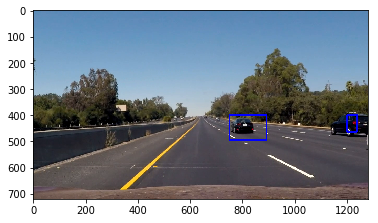

In [9]:
windows_list = []
import moviepy
from moviepy.editor import VideoFileClip
video_output1 = 'Project_Output_1.mp4'
video_input2 = VideoFileClip('project_video.mp4')#.subclip(35, 42)
processed_video = video_input2.fl_image(Pipeline)
%time processed_video.write_videofile(video_output1, audio=False)
video_input2.reader.close()
video_input2.audio.reader.close_proc()